This code is for:

J. P. Cohen, H. Z. Lo, and Y. Bengio, “Count-ception: Counting by Fully Convolutional Redundant Counting,” 2017.
https://arxiv.org/abs/1703.08710

This is a version with a 128x128 receptive field.

Here is a video of the learning in progress:
[![](http://img.youtube.com/vi/ej5bj0mlQq8/0.jpg)](https://www.youtube.com/watch?v=ej5bj0mlQq8)

The cell dataset used in this work is available from [VGG](http://www.robots.ox.ac.uk/~vgg/research/counting/cells.zip) and [Academic Torrents](http://academictorrents.com/details/b32305598175bb8e03c5f350e962d772a910641c)


In [1]:
import sys,os,time,random
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');

import theano
import theano.tensor as T 
import lasagne

import skimage
from skimage.io import imread, imsave
import pickle
import scipy

from os import walk
print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.9.0.dev-RELEASE
lasagne 0.2.dev1


Using cuDNN version 5105 on context None
Mapped name None to device cuda0: TITAN X (Pascal) (0000:09:00.0)


In [2]:
if len(sys.argv) == 3: #on jupyter
    sys.argv = ['jupyter', 'jupyter','0', '32', '1']

print sys.argv;

seed = int(sys.argv[2])
print "seed",seed
nsamples = int(sys.argv[3])
print "nsamples",nsamples
stride = int(sys.argv[4])
print "stride",stride

['jupyter', 'jupyter', '0', '32', '1']
seed 0
nsamples 32
stride 1


In [3]:
scale = 1
patch_size = 128
framesize = 256
noutputs = 1

In [4]:
paramfilename = str(scale) + "-" + str(patch_size) + "-cell2_cell_data.p"
datasetfilename = str(scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + str(stride) + "-cell2-dataset.p"
print paramfilename
print datasetfilename

1-128-cell2_cell_data.p
1-128-256-1-cell2-dataset.p


In [5]:
random.seed(seed)
np.random.seed(seed)
lasagne.random.set_rng(np.random.RandomState(seed))

In [6]:
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, ConcatLayer, Conv2DLayer

input_var = T.tensor4('inputs')
input_var_ex = T.ivector('input_var_ex')

def ConvFactory(data, num_filter, filter_size, stride=1, pad=0, nonlinearity=lasagne.nonlinearities.leaky_rectify):
    data = lasagne.layers.batch_norm(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = ConvFactory(data=data, filter_size=1, pad=0, num_filter=ch_1x1)
    conv3x3 = ConvFactory(data=data, filter_size=3, pad=1, num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat


input_shape = (None, 1, framesize, framesize)
img = InputLayer(shape=input_shape, input_var=input_var[input_var_ex])
net = img


net = ConvFactory(net, filter_size=7, num_filter=64, pad=patch_size)
print net.output_shape
net = SimpleFactory(net, 16, 16)
print net.output_shape
net = SimpleFactory(net, 16, 32)
print net.output_shape
net = ConvFactory(net, filter_size=28, num_filter=16) 
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = SimpleFactory(net, 64, 32)
print net.output_shape
net = SimpleFactory(net, 40, 40)
print net.output_shape
net = SimpleFactory(net, 32, 96)
print net.output_shape
net = ConvFactory(net, filter_size=48, num_filter=16) 
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = SimpleFactory(net, 64, 32)
print net.output_shape
net = SimpleFactory(net, 40, 40)
print net.output_shape
net = SimpleFactory(net, 32, 96)
print net.output_shape
net = ConvFactory(net, filter_size=45, num_filter=32) 
print net.output_shape
net = ConvFactory(net, filter_size=2, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=2, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=2, num_filter=1, stride=stride)
print net.output_shape


(None, 64, 506, 506)
(None, 32, 506, 506)
(None, 48, 506, 506)
(None, 16, 479, 479)
(None, 160, 479, 479)
(None, 96, 479, 479)
(None, 80, 479, 479)
(None, 128, 479, 479)
(None, 16, 432, 432)
(None, 160, 432, 432)
(None, 96, 432, 432)
(None, 80, 432, 432)
(None, 128, 432, 432)
(None, 32, 388, 388)
(None, 64, 387, 387)
(None, 64, 386, 386)
(None, 1, 385, 385)


In [7]:
output_shape = lasagne.layers.get_output_shape(net)
real_input_shape = (None, input_shape[1], input_shape[2]+2*patch_size, input_shape[3]+2*patch_size)
print "real_input_shape:",real_input_shape,"-> output_shape:",output_shape

real_input_shape: (None, 1, 512, 512) -> output_shape: (None, 1, 385, 385)


In [8]:
print (input_shape[2]+2*patch_size)-(patch_size-1)

385


In [9]:
ef = ((patch_size/stride)**2)

prediction = lasagne.layers.get_output(net, deterministic=True)
prediction_count = (prediction/ef).sum(axis=(2,3))

classify = theano.function([input_var, input_var_ex], prediction)

In [10]:
train_start_time = time.time()
print classify(np.zeros((1,1,framesize,framesize), dtype=theano.config.floatX), [0]).shape
print time.time() - train_start_time, "sec"

train_start_time = time.time()
print classify(np.zeros((1,1,framesize,framesize), dtype=theano.config.floatX), [0]).shape
print time.time() - train_start_time, "sec"


(1, 1, 385, 385)
7.82079696655 sec
(1, 1, 385, 385)
7.45281004906 sec


In [11]:
def getMarkersCells(labelPath):        
    lab = imread(labelPath)[:,:,0]/255
    return np.pad(lab,patch_size, "constant")

def getCellCountCells(markers, (x,y,h,w), scale):

    types = [0] * noutputs
    types[0] = markers[y:y+w,x:x+h].sum()
    return types

def getLabelsCells(img, labelPath, base_x, base_y, stride):
    
    width = ((img.shape[0])/stride)+1
    print "label size: ", width
    labels = np.zeros((noutputs, width, width))
    markers = getMarkersCells(labelPath)
    
    for x in range(0,width):
        for y in range(0,width):
            
            count = getCellCountCells(markers,(base_x + x*stride,base_y + y*stride,patch_size,patch_size),scale)  
            for i in range(0,noutputs):
                labels[i][y][x] = count[i]

    count_total = getCellCountCells(markers,(base_x,base_y,framesize+patch_size,framesize+patch_size),scale)
    return labels, count_total

def getTrainingExampleCells(img_raw, labelPath, base_x,  base_y, stride):
    
    img = img_raw[base_y:base_y+framesize,base_x:base_x+framesize]
    img_pad = np.pad(img,patch_size/2, "constant")
    labels, count  = getLabelsCells(img_pad, labelPath, base_x, base_y, stride)
    return img, labels, count

In [12]:
import glob
imgs = []
for filename in glob.iglob('cells/*cell.png'):
    xml = filename.split("cell.png")[0] + "dots.png"
    imgs.append([filename,xml])

In [13]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print path, "bad", path[0]
    if (not os.path.isfile(path[1])):
        print path, "bad", path[1]

In [14]:
if (os.path.isfile(datasetfilename)):
    print "reading", datasetfilename
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset = []
    print len(imgs)
    for path in imgs: 

        imgPath = path[0]
        print imgPath

        im = imread(imgPath)
        img_raw_raw = im.mean(axis=(2)) #grayscale

        img_raw = scipy.misc.imresize(img_raw_raw, (img_raw_raw.shape[0]/scale,img_raw_raw.shape[1]/scale))
        print img_raw_raw.shape," ->>>>", img_raw.shape

        print "input image raw shape", img_raw.shape

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize):
            for base_y in range(0,img_raw.shape[1],framesize):
                img, lab, count = getTrainingExampleCells(img_raw, labelPath, base_y, base_x, stride)
                print "count ", count
                
                ef = patch_size/stride
                lab_est = [(l.sum()/(ef**2)).astype(np.int) for l in lab]
                print "lab_est", lab_est
                
                assert count == lab_est
                
                dataset.append((img,lab,count))
                print "img shape", img.shape
                print "label shape", lab.shape
                sys.stdout.flush()
                    
    print "writing", datasetfilename
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print "DONE"

reading 1-128-256-1-cell2-dataset.p
DONE


In [15]:
np_dataset = np.asarray(dataset)

random.shuffle(np_dataset)

np_dataset = np.rollaxis(np_dataset,1,0)
np_dataset_x = np.asarray([[n] for n in np_dataset[0]],dtype=theano.config.floatX)
np_dataset_y = np.asarray([n for n in np_dataset[1]],dtype=theano.config.floatX)
np_dataset_c = np.asarray([n for n in np_dataset[2]],dtype=theano.config.floatX)

print "np_dataset_x", np_dataset_x.shape
print "np_dataset_y", np_dataset_y.shape
print "np_dataset_c", np_dataset_c.shape

np_dataset_x (200, 1, 256, 256)
np_dataset_y (200, 1, 385, 385)
np_dataset_c (200, 1)


In [16]:
del np_dataset

In [17]:
length = len(np_dataset_x)

n = nsamples

np_dataset_x_train = np_dataset_x[0:n]
np_dataset_y_train = np_dataset_y[0:n]
np_dataset_c_train = np_dataset_c[0:n]
print "np_dataset_x_train", len(np_dataset_x_train)

np_dataset_x_valid = np_dataset_x[n:2*n]
np_dataset_y_valid = np_dataset_y[n:2*n]
np_dataset_c_valid = np_dataset_c[n:2*n]
print "np_dataset_x_valid", len(np_dataset_x_valid)

np_dataset_x_test = np_dataset_x[100:]
np_dataset_y_test = np_dataset_y[100:]
np_dataset_c_test = np_dataset_c[100:]
print "np_dataset_x_test", len(np_dataset_x_test)

np_dataset_x_train 32
np_dataset_x_valid 32
np_dataset_x_test 100


In [18]:
np_dataset_x_train[:4,0].shape

(4, 256, 256)

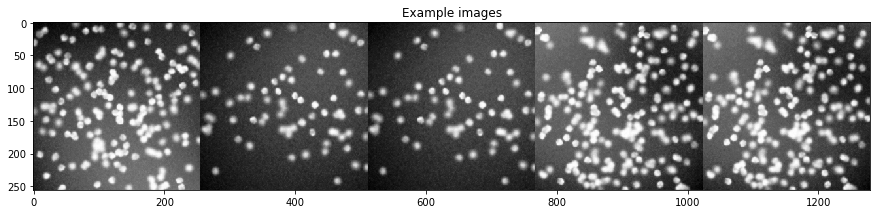

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_x_train[:5,0],axis=1), interpolation='none', cmap='Greys_r')

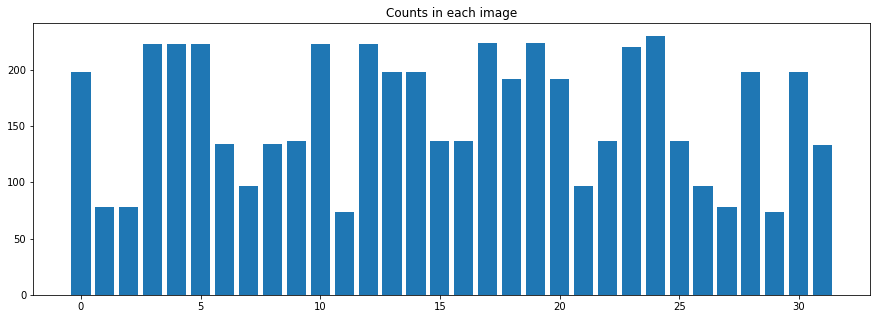

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Counts in each image")
plt.bar(range(len(np_dataset_c_train)),np_dataset_c_train);

In [21]:
print "Total cells in training", np.sum(np_dataset_c_train[0:], axis=0)
print "Total cells in validation", np.sum(np_dataset_c_valid[0:], axis=0)
print "Total cells in testing", np.sum(np_dataset_c_test[0:], axis=0)

Total cells in training [ 5146.]
Total cells in validation [ 6032.]
Total cells in testing [ 18693.]


In [22]:
#to make video: ffmpeg -i image-0-%d-cell.png -vcodec libx264 aout.mp4
def processImages(name, i):
    fig = plt.Figure(figsize=(18, 9), dpi=160)
    gcf = plt.gcf()
    gcf.set_size_inches(18, 15)
    fig.set_canvas(gcf.canvas)
    
    (img, lab, count) = dataset[i]
    
    print str(i),count
    pcount = classify([[img]], [0])[0]
    
    ef = patch_size/stride
    lab_est = [(l.sum()/(ef**2)).astype(np.int) for l in lab]
    pred_est = [(l.sum()/(ef**2)).astype(np.int) for l in pcount]
    
    print str(i),"label est ",lab_est," --> predicted est ",pred_est

    ax2 = plt.subplot2grid((2,4), (0, 0), colspan=2)
    ax3 = plt.subplot2grid((2,4), (0, 2), colspan=3)
    ax4 = plt.subplot2grid((2,4), (1, 2), colspan=3)
    ax5 = plt.subplot2grid((2,4), (1, 0), rowspan=1)
    ax6 = plt.subplot2grid((2,4), (1, 1), rowspan=1)

    ax2.set_title("Input Image")
    ax2.imshow(img, interpolation='none', cmap='Greys_r')
    ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
    ax3.imshow(np.concatenate((lab),axis=1), interpolation='none')
    ax4.set_title("Predicted counts")
    ax4.imshow(np.concatenate((pcount),axis=1), interpolation='none')

    ax5.set_title("Real " + str(lab_est))
    ax5.set_ylim((0, np.max(lab_est)*2))
    ax5.set_xticks(np.arange(0, noutputs, 1.0))
    ax5.bar(range(noutputs),lab_est, align='center')
    ax6.set_title("Pred " + str(pred_est))
    ax6.set_ylim((0, np.max(lab_est)*2))
    ax6.set_xticks(np.arange(0, noutputs, 1.0))
    ax6.bar(range(noutputs),pred_est, align='center')
    
    fig.savefig('images-cell/image-' + str(i) + "-" + name + '.png')


In [23]:
import pickle, os

directory = "network-temp/"
ext = "countception.p"

if not os.path.exists(directory):
    os.makedirs(directory)
    
def save_network(net,name):
    pkl_params = lasagne.layers.get_all_param_values(net, trainable=True)
    out = open(directory + str(name) + ext, "w", 0) #bufsize=0
    pickle.dump(pkl_params, out)
    out.close()

def load_network(net,name):
    all_param_values = pickle.load(open(directory + str(name) + ext, "r" ))
    lasagne.layers.set_all_param_values(net, all_param_values, trainable=True)

In [24]:
def re_init_network(net, re_seed):
    
    np.random.seed(re_seed)
    lasagne.random.set_rng(np.random.RandomState(re_seed))
    
    old = lasagne.layers.get_all_param_values(net, trainable=True)
    new = []
    for layer in old:
        shape = layer.shape
        if len(shape)<2:
            shape = (shape[0], 1)
        W= lasagne.init.GlorotUniform()(shape)
        if W.shape != layer.shape:
            W = np.squeeze(W, axis= 1)
        new.append(W)
    lasagne.layers.set_all_param_values(net, new, trainable=True)

In [25]:
#test accuracy
def test_perf(dataset_x, dataset_y, dataset_c):

    ef = patch_size/stride
    testpixelerrors = []
    testerrors = []
    bs = 1
    for i in range(0,len(dataset_x), bs):

        pcount = classify(dataset_x,range(i,i+bs))
        pixelerr = np.abs(pcount - dataset_y[i:i+bs]).mean(axis=(2,3))
        testpixelerrors.append(pixelerr)
        
        pred_est = (pcount/(ef**2)).sum(axis=(1,2,3))
        err = np.abs(dataset_c[i:i+bs].flatten()-pred_est)
        
        testerrors.append(err)
    
    return np.abs(testpixelerrors).mean(), np.abs(testerrors).mean()

In [26]:
# print "Random performance"
# print test_perf(np_dataset_x_train, np_dataset_y_train, np_dataset_c_train)
# print test_perf(np_dataset_x_valid, np_dataset_y_valid, np_dataset_c_valid)
# print test_perf(np_dataset_x_test, np_dataset_y_test, np_dataset_c_test)

In [27]:
re_init_network(net,seed)

In [28]:
target_var = T.tensor4('target')
lr = theano.shared(np.array(0.005, dtype=theano.config.floatX))

#Mean Absolute Error is computed between each count of the count map
l1_loss = T.abs_(prediction - target_var[input_var_ex])

#Mean Absolute Error is computed for the overall image prediction
ef = ((patch_size/stride)**2)
prediction_count2 =(prediction/ef).sum(axis=(2,3))
mae_loss = T.abs_(prediction_count2 - (target_var[input_var_ex]/ef).sum(axis=(2,3))) 

loss = l1_loss.mean()

params = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=lr)

train_fn = theano.function([input_var_ex], [loss,mae_loss], updates=updates,
                         givens={input_var:np_dataset_x_train, target_var:np_dataset_y_train})

print "DONE compiling theano functons"

DONE compiling theano functons


In [30]:
batch_size = 2

print "batch_size", batch_size
print "lr", lr.eval()

best_valid_err = 99999999
best_test_err = 99999999
datasetlength = len(np_dataset_x_train)
print "datasetlength",datasetlength

for epoch in range(1000):
    start_time = time.time()

    epoch_err_pix = []
    epoch_err_pred = []
    todo = range(datasetlength)    
    
    for i in range(0,datasetlength, batch_size):
        ex = todo[i:i+batch_size]

        train_start_time = time.time()
        err_pix,err_pred = train_fn(ex)
        train_elapsed_time = time.time() - train_start_time

        epoch_err_pix.append(err_pix)
        epoch_err_pred.append(err_pred)

    valid_pix_err, valid_err = test_perf(np_dataset_x_valid, np_dataset_y_valid, np_dataset_c_valid)

    # a threshold is used to reduce processing when we are far from the goal
    if (valid_err < 5 and valid_err < best_valid_err):
        best_valid_err = valid_err
        best_test_err = test_perf(np_dataset_x_test, np_dataset_y_test,np_dataset_c_test)
        print "OOO best test (err_pix, err_pred)", best_test_err, ", epoch",epoch
        save_network(net,"best_valid_err")


    elapsed_time = time.time() - start_time
    err = np.mean(epoch_err_pix)
    acc = np.mean(np.concatenate(epoch_err_pred))
    
    print "#" + str(epoch) + "# (err_pix:" + str(np.around(err,3)) + ", err_pred:" +  str(np.around(acc,3)) + "), valid (err_pix:" + str(np.around(valid_pix_err,3)) + ", err_pred:" + str(np.around(valid_err,3)) +"), (time:" + str(np.around(elapsed_time,3)) + "sec)"

    #visualize training
    #processImages(str(epoch) + '-cell',0)

print "#####", "best_test_acc", best_test_err, "stride", stride, sys.argv


batch_size 2
lr 0.00499999988824
datasetlength 32
#0# (err_pix:9.188, err_pred:70.169), valid (err_pix:11.929, err_pred:103.467), (time:719.448sec)
#1# (err_pix:14.512, err_pred:127.024), valid (err_pix:19.392, err_pred:173.774), (time:716.874sec)
#2# (err_pix:13.086, err_pred:104.142), valid (err_pix:9.767, err_pred:63.483), (time:716.91sec)
#3# (err_pix:10.653, err_pred:83.23), valid (err_pix:7.85, err_pred:40.861), (time:717.049sec)
#4# (err_pix:6.87, err_pred:45.226), valid (err_pix:8.041, err_pred:61.206), (time:716.934sec)
#5# (err_pix:9.37, err_pred:74.648), valid (err_pix:6.168, err_pred:31.446), (time:717.217sec)
#6# (err_pix:6.258, err_pred:39.707), valid (err_pix:7.336, err_pred:52.707), (time:739.722sec)
#7# (err_pix:6.411, err_pred:44.289), valid (err_pix:6.358, err_pred:39.374), (time:755.374sec)
#8# (err_pix:7.84, err_pred:59.417), valid (err_pix:14.069, err_pred:125.782), (time:756.564sec)
#9# (err_pix:8.064, err_pred:61.334), valid (err_pix:5.754, err_pred:20.329), (ti

KeyboardInterrupt: 

In [ ]:
print "Done"

In [ ]:
#load best network
load_network(net,"best_valid_err")

In [31]:
def compute_counts(dataset_x):

    ef = patch_size/stride
    bs = 1
    ests = []
    for i in range(0,len(dataset_x), bs):
        pcount = classify(dataset_x,range(i,i+bs))
        pred_est = (pcount/(ef**2)).sum(axis=(1,2,3))        
        ests.append(pred_est)
    return ests

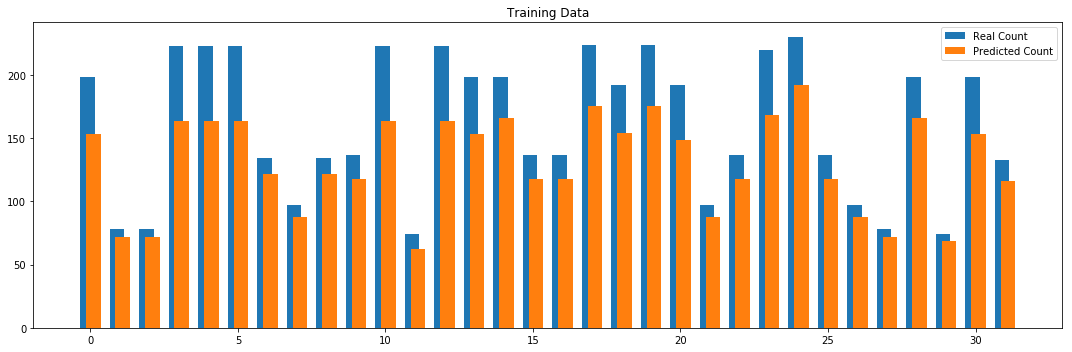

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Training Data")

pcounts = compute_counts(np_dataset_x_train)
plt.bar(np.arange(len(np_dataset_c_train))-0.1,np_dataset_c_train, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_train))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

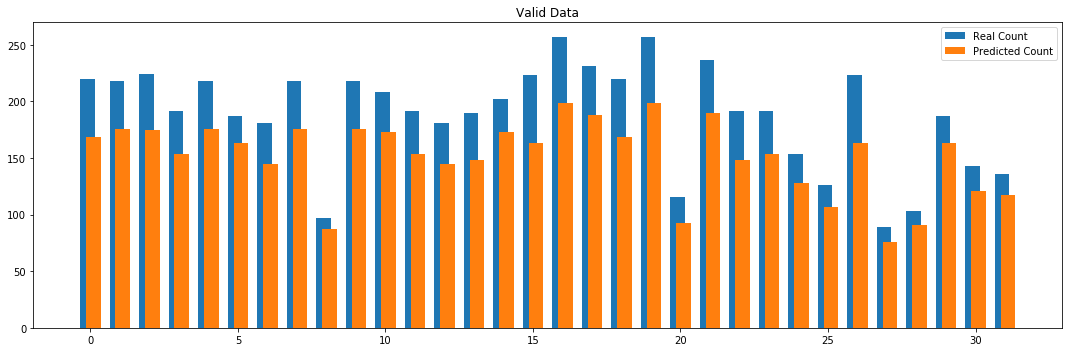

In [33]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Valid Data")

pcounts = compute_counts(np_dataset_x_valid)
plt.bar(np.arange(len(np_dataset_c_valid))-0.1,np_dataset_c_valid, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_valid))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Test Data")

pcounts = compute_counts(np_dataset_x_test)
plt.bar(np.arange(len(np_dataset_c_test))-0.1,np_dataset_c_test, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_test))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

8 [220]
8 label est  [220]  --> predicted est  [168]


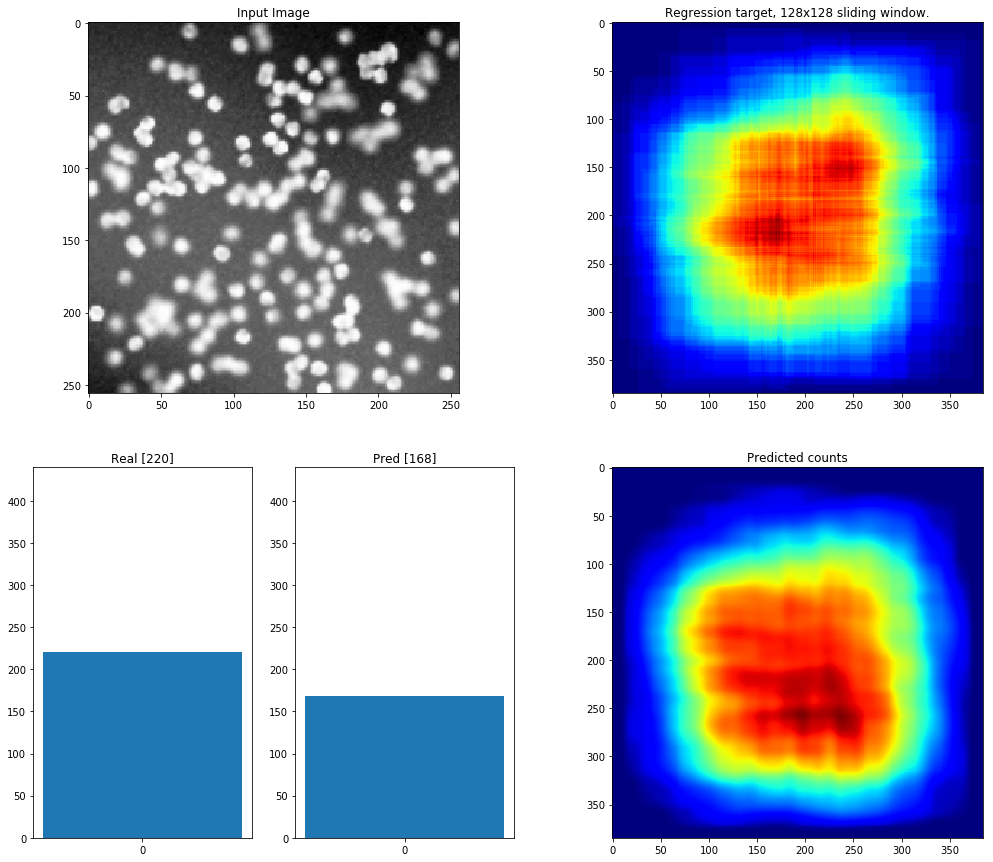

In [35]:
%matplotlib inline
processImages('test',8)

1 [78]
1 label est  [78]  --> predicted est  [72]


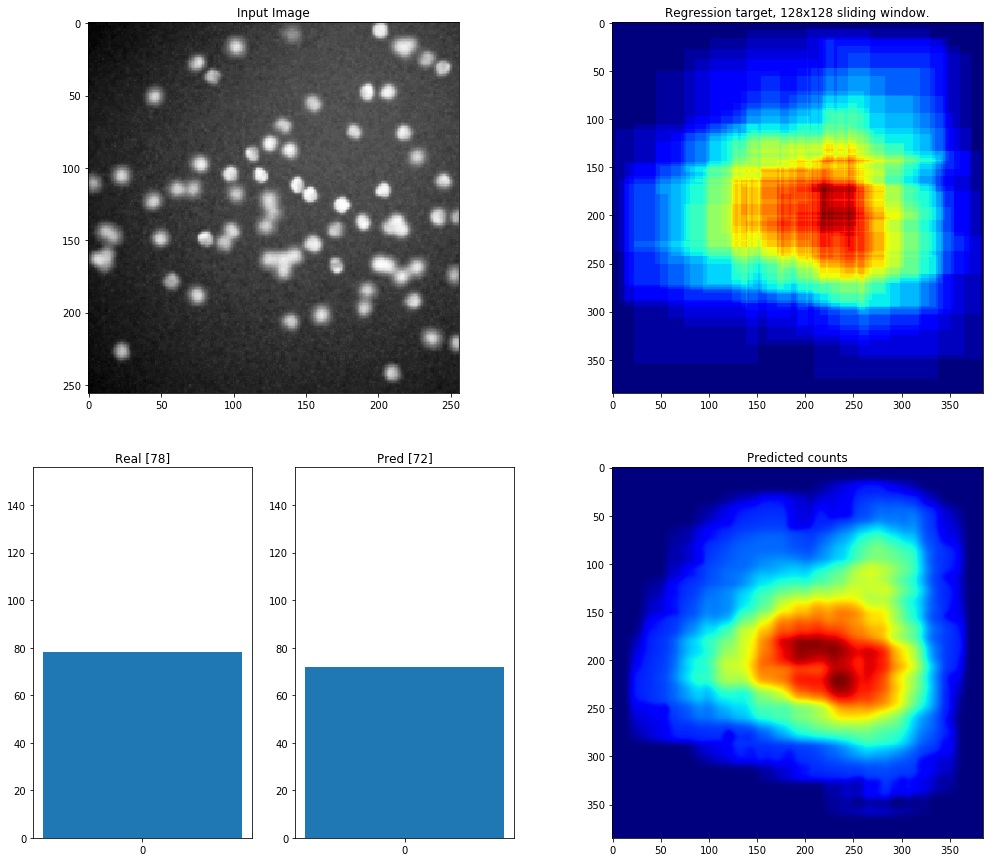

In [36]:
%matplotlib inline
processImages('test',1)

2 [223]
2 label est  [223]  --> predicted est  [163]


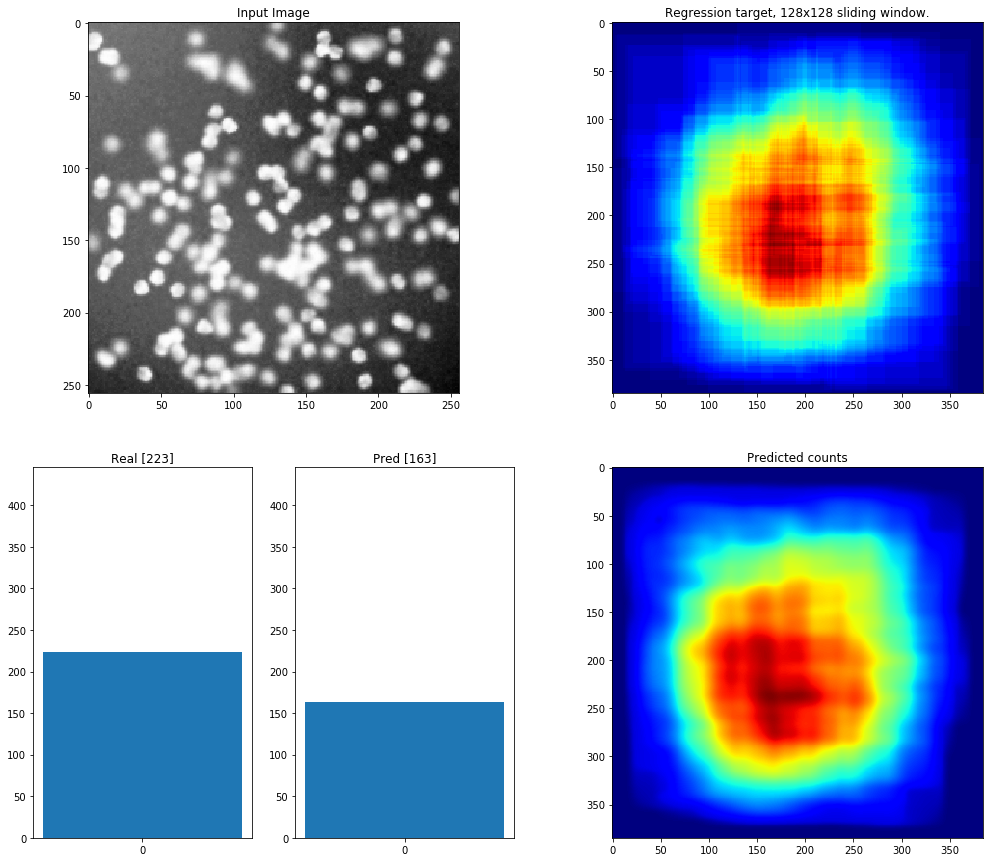

In [37]:
%matplotlib inline
processImages('test',2)

3 [134]
3 label est  [134]  --> predicted est  [121]


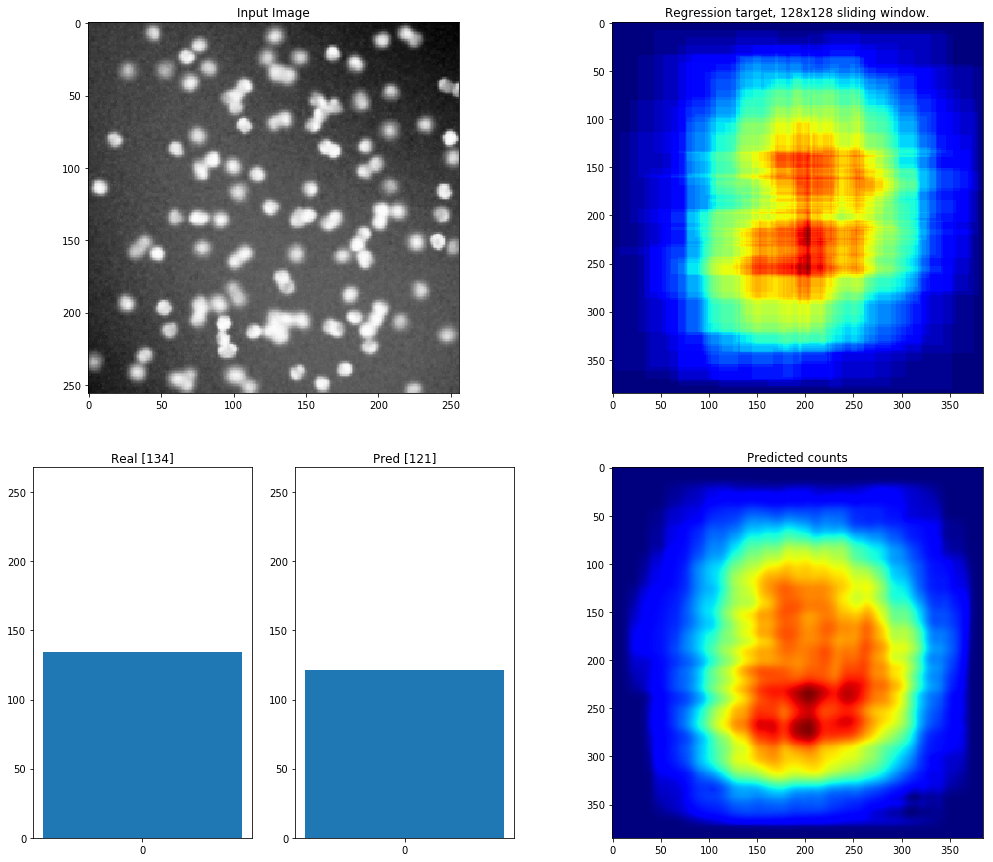

In [38]:
%matplotlib inline
processImages('test',3)

4 [74]
4 label est  [74]  --> predicted est  [62]


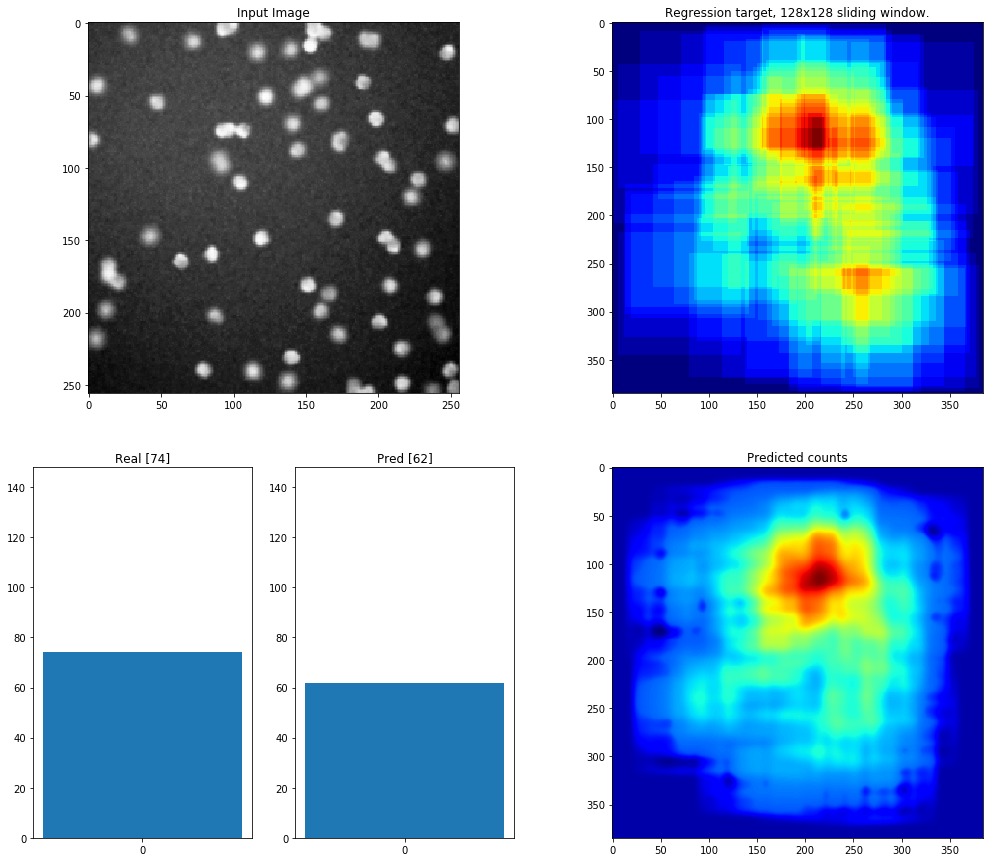

In [39]:
%matplotlib inline
processImages('test',4)

5 [126]
5 label est  [126]  --> predicted est  [106]


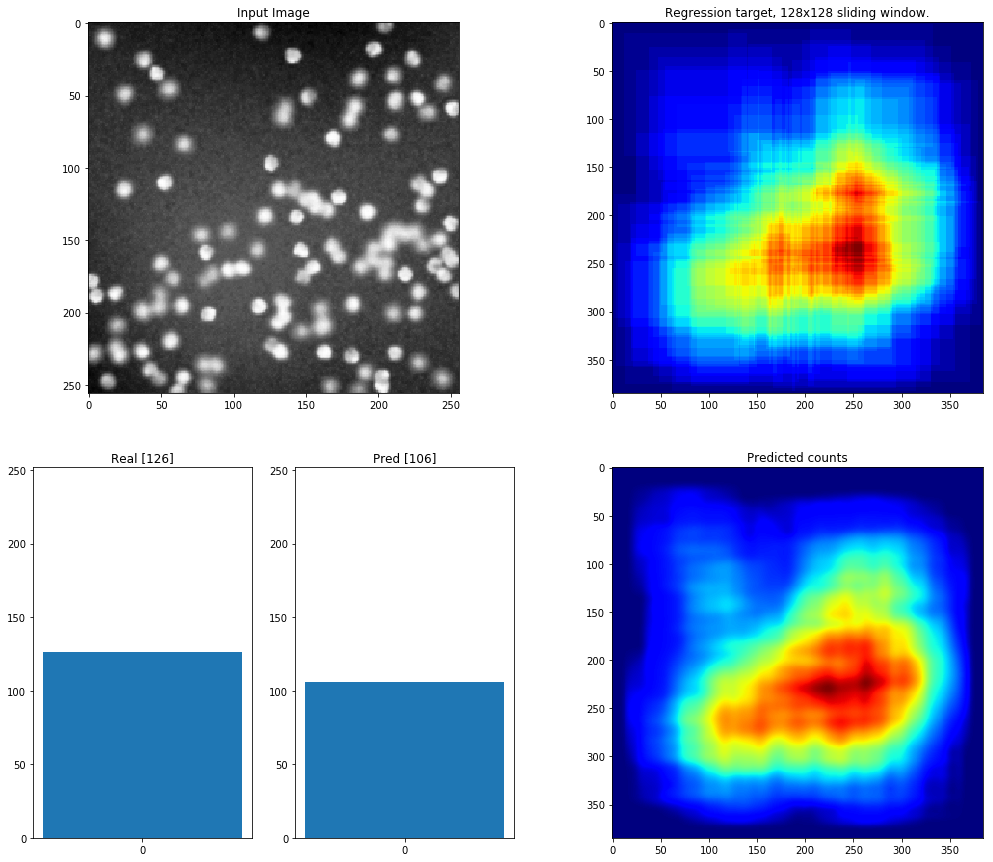

In [40]:
%matplotlib inline
processImages('test',5)

6 [137]
6 label est  [137]  --> predicted est  [117]


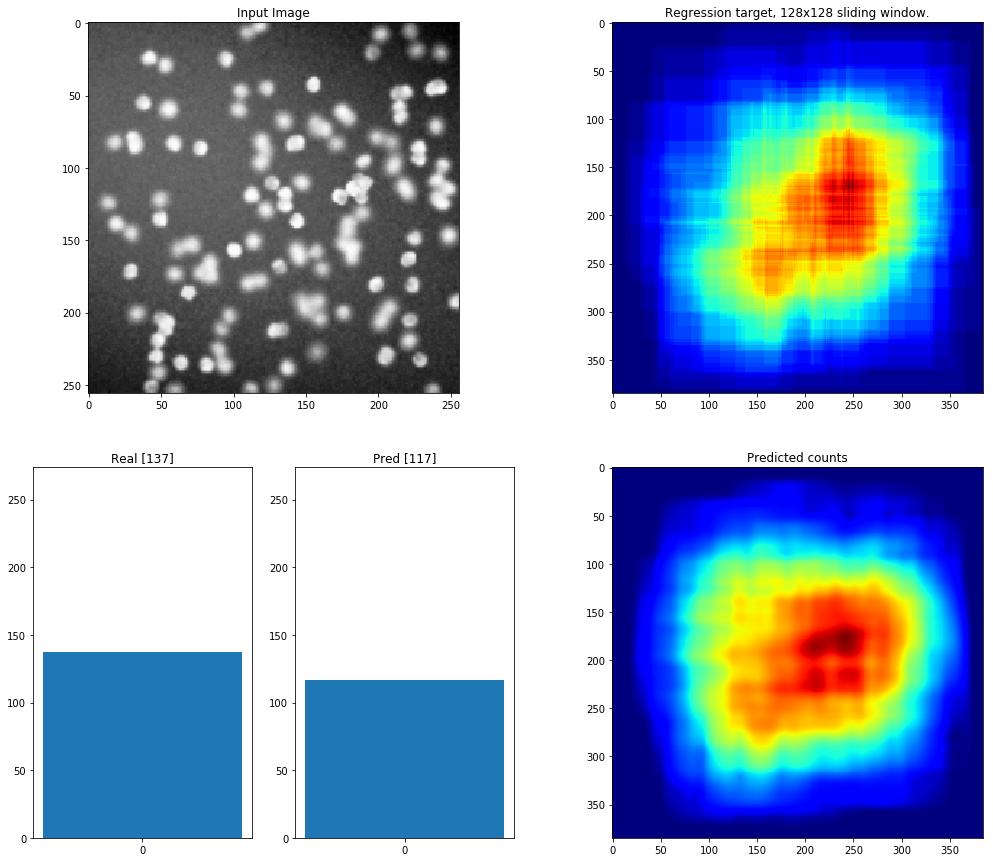

In [41]:
%matplotlib inline
processImages('test',6)